In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import time
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler 

## Load the full dataset

In [4]:
moves_df = pd.read_csv("../Data/full_moves_df.csv")

In [5]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key,differences,class
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550,35,2
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928,13,2
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293,63,2
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878,-64,2
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797,5,2
...,...,...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493,-6,2
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573,4,2
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641,14,2
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311,13,2


### Create the sets

In [6]:
nb_unique_moves = moves_df.moves.nunique()
print(f"There are {nb_unique_moves} unique moves in the dataset.")

There are 1895 unique moves in the dataset.


In [7]:
# There are not so many unique moves in the dataset
# however, because there are 9M moves, using one-hot encoding would be very demanding in terms of memory usage
# thus, we'll use target encoding to encode the moves
# the target will be the mean of the evaluation of the positions associated to each unique move

In [8]:
moves_df['target_enc'] = moves_df.groupby("moves")["evaluation"].transform("mean")

In [9]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key,differences,class,target_enc
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550,35,2,34.303237
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928,13,2,60.633977
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293,63,2,34.887448
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878,-64,2,48.062981
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797,5,2,42.837878
...,...,...,...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493,-6,2,55.805796
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573,4,2,-36.787252
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641,14,2,55.584858
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311,13,2,28.956712


In [10]:
X = moves_df[['target_enc', 'zobrist_key']]
y = moves_df['class']

### Scale the data

In [11]:
sc = MinMaxScaler()
sc.fit(np.array(X.zobrist_key).reshape(-1, 1))

MinMaxScaler()

In [12]:
scaled_zob_key = sc.transform(np.array(X.zobrist_key).reshape(-1, 1))

In [13]:
X['zobrist_key'] = scaled_zob_key

In [14]:
X

,target_enc,zobrist_key
0,34.303237,0.508737
1,60.633977,0.032296
2,34.887448,0.824715
3,48.062981,0.471888
4,42.837878,0.293266
...,...,...
9023518,55.805796,0.755439
9023519,-36.787252,0.977338
9023520,55.584858,0.159260
9023521,28.956712,0.649342


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

## Helpful functions

In [16]:
def accuracy(y_test, pred):
    #calculate the accuracy of a prediction
    acc = accuracy_score(y_test, pred)
    print(f"Accuracy = {round(100*acc, 2)}%")

In [17]:
def cf_matrix(y_test, pred, pct_row=False, pct_col=False):
    #using seaborn
    #this functions plots the confusion matrix of a prediction vector
    #it can plot the function either with full values, or with percentages calculated either by row or column
    cf_matrix = confusion_matrix(y_test, pred)
    
    if not pct_row and not pct_col:
        cf_matrix_display = cf_matrix
        fmt="d"
        
    if pct_row:
        fmt=".2f"
        cf_matrix_display = np.zeros((len(cf_matrix), len(cf_matrix[0])))
        for i in range(len(cf_matrix)):
            sum_ = sum(cf_matrix[i])
            for j in range(len(cf_matrix[i])):
                cf_matrix_display[i][j] = 100*cf_matrix[i][j]/sum_
        
    elif pct_col:
        fmt=".2f"
        col_sum = []
        for j in range(len(cf_matrix[0])):
            sum_=0
            for i in range(len(cf_matrix)):
                sum_+=cf_matrix[i][j]
            col_sum.append(sum_)
        cf_matrix_display = np.zeros((len(cf_matrix), len(cf_matrix[0])))
        for i in range(len(cf_matrix)):
            for j in range(len(cf_matrix[0])):
                cf_matrix_display[i][j] = 100*cf_matrix[i][j]/col_sum[j]
        
    fig = plt.figure(figsize=(10,7))
    ax = sns.heatmap(cf_matrix_display, annot=True, cmap='Blues', fmt=fmt)

    ax.set_title('Matrice de Confusion avec labels \n')
    ax.set_xlabel('\nValeurs Prédites')
    ax.set_ylabel('Valeurs Réelles')
    if pct_row or pct_col:
        for t in ax.texts: t.set_text(t.get_text() + " %")
    plt.show()

## Standard Random Forest

We first try to implement a Random Forest algorithm to predict the class of a chess move. The idea is to train the algorithm to understand what a good or bad move is. 

In [16]:
clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [17]:
pred = clf.predict(X_test)

In [18]:
accuracy(y_test, pred)

Accuracy = 77.94%


The accuracy seems pretty high. However, it is not actually the case, this is due to the imbalance aspect of the set, and the fact that class 2 is overly represented compared to the other classes. Thus, by predicting almost always the class 2, the accuracy becomes quite high but the model is not a good predictor of the other classes. 

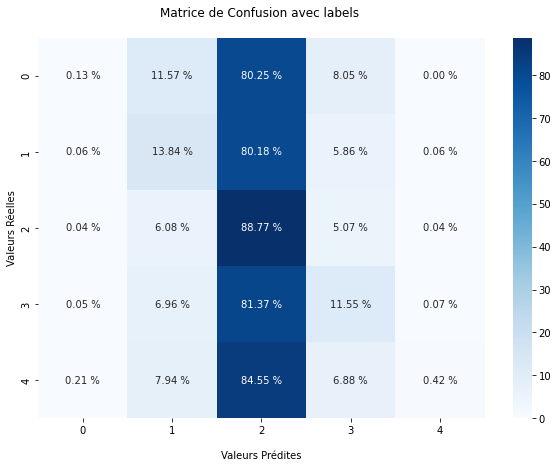

In [19]:
cf_matrix(y_test, pred, pct_row=True)

In [23]:
f1_average_weighted = f1_score(y_test, pred, average='weighted')
print(f"Weighted average of the F1-score of each class = {f1_average_weighted}")
f1 = f1_score(y_test, pred, average=None)
print(f"F1-score for each class = {f1}")

Weighted average of the F1-score of each class = 0.7725012929856815
F1-score for each class = [0.00133958 0.14729359 0.87816534 0.12428405 0.00461627]


The class 2 is predicted very well, but the other classes are terrible

##### Add weights to the Random Forest

In [23]:
#we add weights associated to each class, given more importance to the least populated classes
#the weight of each class is equal to the inverse of their population

_, population_by_class = np.unique(moves_df['class'], return_counts=True)
class_weights = [1/x for x in population_by_class]
weights = {}
for i in range(len(class_weights)):
    weights[i] = class_weights[i]
    
weights

{0: 0.00025144581342720644,
 1: 1.4454585138951926e-06,
 2: 1.2921452557336362e-07,
 3: 1.7125369693918267e-06,
 4: 0.0002115506663845991}

In [24]:
clf = RandomForestClassifier(class_weight=weights, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight={0: 0.00025144581342720644,
                                     1: 1.4454585138951926e-06,
                                     2: 1.2921452557336362e-07,
                                     3: 1.7125369693918267e-06,
                                     4: 0.0002115506663845991},
                       n_jobs=-1)

In [25]:
pred = clf.predict(X_test)
accuracy(y_test, pred)

Accuracy = 77.58%


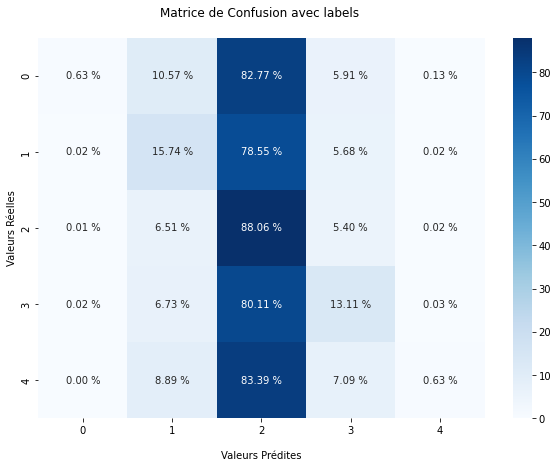

In [26]:
cf_matrix(y_test, pred, pct_row=True)

Adding the weights to the random forest has changed almost nothing

## Balanced random forest

In [27]:
#adding weights to the random forest is not enough to counter the effect of the imbalance in the classes
#we try to use a balanced random forest instead to counter this effect 

BRFC = BalancedRandomForestClassifier(n_estimators=100, n_jobs=-1, verbose=10)

A balanced random forest is a random forest in which each tree of the forest will be provided a balanced bootstrap sample, to account for the imbalance of our dataset. 

In [28]:
start = time.time()

BRFC.fit(X_train, y_train)

stop = time.time()
t = stop-start

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 2 of 100
building tree 10 of 100
building tree 3 of 100
building tree 8 of 100
building tree 5 of 100
building tree 11 of 100
building tree 4 of 100
building tree 1 of 100
building tree 12 of 100
building tree 7 of 100
building tree 6 of 100


[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   14.0s


building tree 9 of 100
building tree 14 of 100
building tree 19 of 100
building tree 24 of 100
building tree 17 of 100
building tree 16 of 100
building tree 18 of 100
building tree 23 of 100
building tree 20 of 100
building tree 13 of 100
building tree 22 of 100
building tree 15 of 100
building tree 21 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   27.8s


building tree 28 of 100
building tree 25 of 100
building tree 34 of 100
building tree 26 of 100
building tree 27 of 100
building tree 33 of 100
building tree 36 of 100
building tree 29 of 100
building tree 31 of 100building tree 35 of 100

building tree 32 of 100
building tree 30 of 100


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   42.1s


building tree 42 of 100
building tree 38 of 100
building tree 40 of 100
building tree 37 of 100
building tree 41 of 100
building tree 39 of 100
building tree 47 of 100
building tree 43 of 100
building tree 46 of 100
building tree 45 of 100
building tree 48 of 100
building tree 44 of 100


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   55.9s
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   56.0s


building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 59 of 100building tree 49 of 100

building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 53 of 100
building tree 60 of 100
building tree 54 of 100
building tree 62 of 100
building tree 66 of 100
building tree 64 of 100building tree 65 of 100
building tree 63 of 100

building tree 68 of 100
building tree 61 of 100
building tree 71 of 100
building tree 69 of 100
building tree 67 of 100
building tree 72 of 100
building tree 70 of 100


[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  1.4min


building tree 74 of 100
building tree 75 of 100
building tree 77 of 100
building tree 80 of 100
building tree 81 of 100
building tree 76 of 100
building tree 73 of 100
building tree 78 of 100
building tree 79 of 100
building tree 84 of 100
building tree 82 of 100
building tree 83 of 100


[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  1.6min


building tree 85 of 100
building tree 88 of 100
building tree 91 of 100
building tree 87 of 100
building tree 90 of 100building tree 94 of 100
building tree 86 of 100

building tree 93 of 100
building tree 89 of 100
building tree 95 of 100
building tree 96 of 100
building tree 92 of 100


[Parallel(n_jobs=-1)]: Done  88 out of 100 | elapsed:  1.8min remaining:   15.0s


building tree 97 of 100
building tree 98 of 100
building tree 100 of 100
building tree 99 of 100


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished


In [29]:
print(f"Took {round(t, 2)}s to run")

Took 117.59s to run


In [35]:
pred = BRFC.predict(X_test)
accuracy(y_test, pred)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    0.9s
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:    1.7s
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=12)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=12)]: Done  48 tasks      | elapsed:    3.6s
[Parallel(n_jobs=12)]: Done  61 tasks      | elapsed:    4.8s
[Parallel(n_jobs=12)]: Done  74 tasks      | elapsed:    5.7s
[Parallel(n_jobs=12)]: Done  88 out of 100 | elapsed:    6.7s remaining:    0.8s


Accuracy = 28.98%


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    7.2s finished


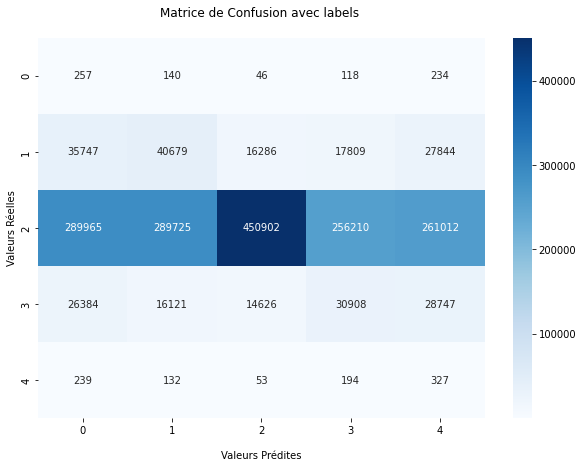

In [34]:
cf_matrix(y_test, pred)

#### Cross-Validation - RandomizedSearch

In [35]:
#using the balanced random forest seems to have had an effect, with the accuracy dropping by a lot
#we'll then do a grid search to try and find better hyperparameters to improve the efficiency of the model

In [19]:
# Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# max_features is the number of dimension considered to select the best split (the dimension along which a cell is cut)
max_features = ['log2', 'sqrt']
# The maximum depth of the tree corresponds to the maximum number of levels of the tree. 
# If not given, splits are performed until all cells contain less than min_samples_split samples.
max_depth = np.arange(5,100,5)
# min_samples_split is the minimum number of samples in a cell to allow a split.
min_samples_split = [2, 3, 4, 5, 6, 7, 8]
# A split is considered in the tree if it leaves at least min_samples_leaf training samples in each 
# subcell obtained after the spliting process.
min_samples_leaf = [1, 2, 3, 4]
# if bootstrap is true all the training dataset is used to build each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [17]:
BRFC = BalancedRandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = BRFC, param_distributions = random_grid, n_iter = 100, 
                               cv = 2, verbose=10, n_jobs = -1)

In [18]:
start = time.time()

rf_random.fit(X_train, y_train)

stop = time.time()
print(round(stop-start, 2), 's')

Fitting 2 folds for each of 100 candidates, totalling 200 fits
[CV 2/2; 7/100] START bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=248
[CV 2/2; 7/100] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=248;, score=0.277 total time= 6.3min
[CV 2/2; 16/100] START bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=466
[CV 2/2; 16/100] END bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=466;, score=0.270 total time=12.6min


/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/2; 7/100] START bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=248
[CV 1/2; 7/100] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=4, min_samples_split=4, n_estimators=248;, score=0.281 total time= 6.3min
[CV 1/2; 16/100] START bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=466
[CV 1/2; 16/100] END bootstrap=False, max_depth=35, max_features=log2, min_samples_leaf=1, min_samples_split=6, n_estimators=466;, score=0.272 total time=12.7min
[CV 2/2; 15/100] START bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=474
[CV 2/2; 15/100] END bootstrap=False, max_depth=25, max_features=log2, min_samples_leaf=4, min_samples_split=6, n_estimators=474;, score=0.277 total time=12.1min
[CV 1/2; 23/100] START bootstrap=False, max_depth=35, max_features=sqrt, min_samples_leaf=2, min_samples_split=3, n_estimat

In [19]:
# display the best parameters
rf_random.best_params_

{'n_estimators': 402,
 'min_samples_split': 6,
 'min_samples_leaf': 3,
 'max_features': 'sqrt',
 'max_depth': 5,
 'bootstrap': False}

In [20]:
best_random = rf_random.best_estimator_
pred = best_random.predict(X_test)

In [24]:
best_random = rf_random.best_estimator_
pred = best_random.predict(X_test)
acc = accuracy_score(y_test, pred)
print(f"Accuracy = {round(100*acc, 2)}%")

Accuracy = 46.27%


In [22]:
cf_matrix = confusion_matrix(y_test, pred)

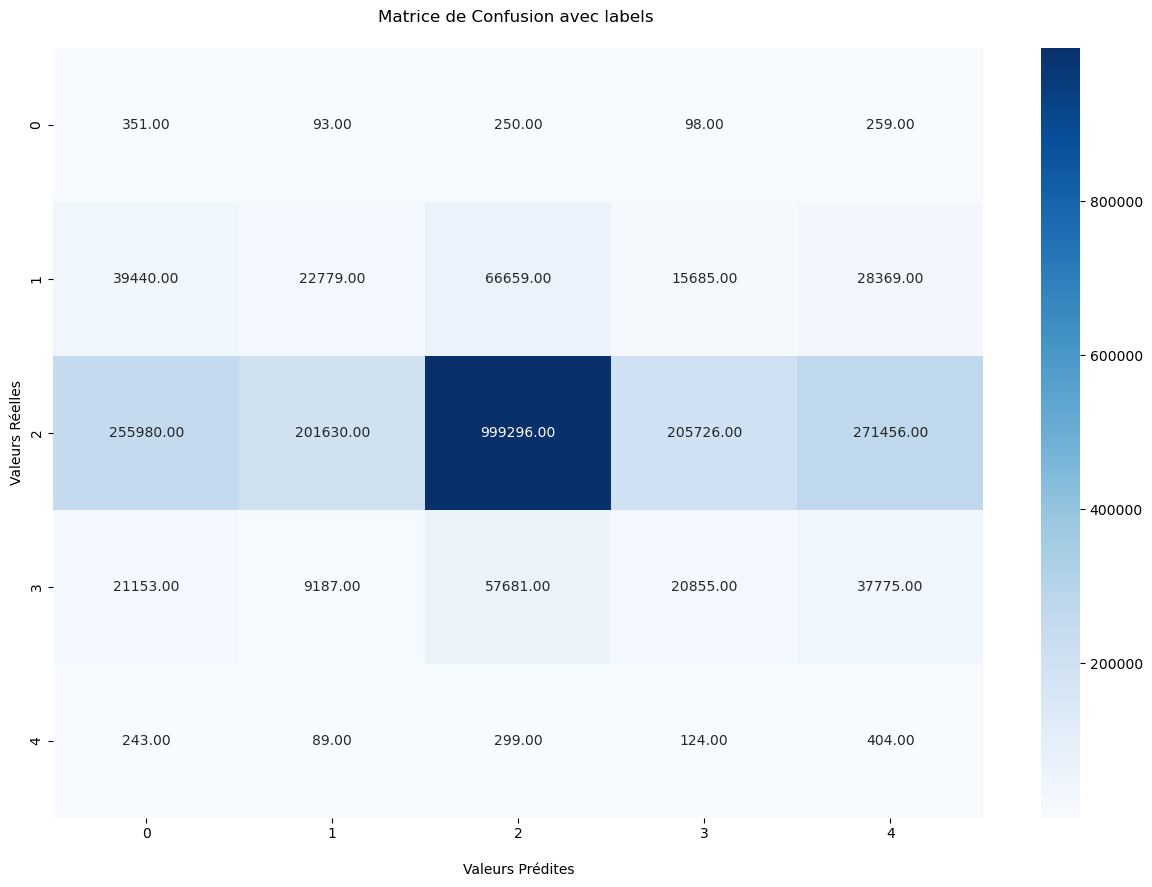

In [23]:
fig = plt.figure(figsize=(15,10))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt=".2f")

ax.set_title('Matrice de Confusion avec labels \n')
ax.set_xlabel('\nValeurs Prédites')
ax.set_ylabel('Valeurs Réelles')
#for t in ax.texts: t.set_text(t.get_text() + " %")
## Ticket labels - List must be in alphabetical order
#ax.xaxis.set_ticklabels(['-', '0', '+' ])
#ax.yaxis.set_ticklabels(['-', '0', '+'])

## Display the visualization of the Confusion Matrix.
plt.show()

There is some improvement. The accuracy being close to 50% shows that the model is being more able now to distinguish between classes, and tries to predict the class rather than merely predicting the class 2 every time. However, to find the best hyperparameters, we would need to run a very thorough GridSearch instead of a RandomizedSearch, which would take a very long time. Furthermore, we are not sure that the final results would be this good, accuracy should go up, but it may go up only just a bit. Thus, we'll try other techniques to try and train a model to predict the quality of a move. 

## Use under-sampling

In [48]:
## the previous attempts were not successful, the class 2 is way too prominent to effectively train the model
## in this part, we will undersample each class to have the same amount of elements in each class

In [53]:
print('Original dataset shape %s' % Counter(y_train))
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({2: 6965161, 1: 622640, 3: 525536, 4: 4254, 0: 3579})
Resampled dataset shape Counter({0: 3579, 1: 3579, 2: 3579, 3: 3579, 4: 3579})


In [32]:
start = time.time()

clf = RandomForestClassifier(n_jobs=-1)
clf.fit(X_res, y_res)

stop = time.time()
print(f"Took {round(stop-start, 2)}s to run.")

Took 0.61s to run.


In [33]:
pred = clf.predict(X_test)
accuracy(y_test, pred)

Accuracy = 30.58%


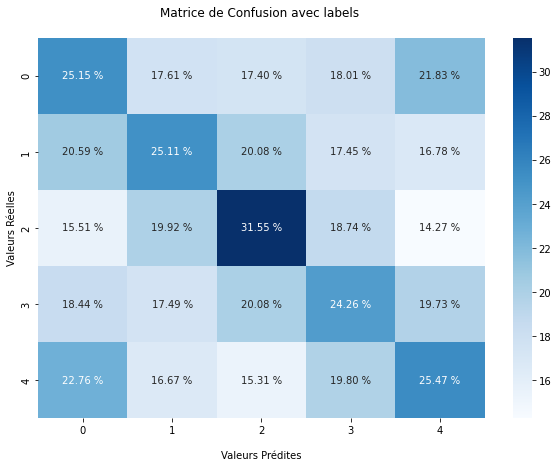

In [34]:
cf_matrix(y_test, pred, pct_row=True)

#### RandomizedSearch with under-sampled data

In [28]:
clf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 2000, cv = 3, verbose=10, n_jobs = -1)

In [29]:
start = time.time()

rf_random.fit(X_res, y_res)

stop = time.time()

Fitting 3 folds for each of 2000 candidates, totalling 6000 fits
[CV 2/3; 7/2000] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=539
[CV 2/3; 7/2000] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=539;, score=0.285 total time=   5.0s
[CV 1/3; 12/2000] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=612
[CV 1/3; 12/2000] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=612;, score=0.255 total time=  12.5s


/opt/mamba/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/3; 7/2000] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=539
[CV 1/3; 7/2000] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=539;, score=0.297 total time=   5.1s
[CV 2/3; 12/2000] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=612
[CV 2/3; 12/2000] END bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estimators=612;, score=0.260 total time=  12.5s
[CV 3/3; 7/2000] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=539
[CV 3/3; 7/2000] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=3, min_samples_split=3, n_estimators=539;, score=0.299 total time=   5.5s
[CV 3/3; 12/2000] START bootstrap=False, max_depth=25, max_features=sqrt, min_samples_leaf=1, min_samples_split=3, n_estima

In [34]:
print(round(stop-start, 2), 's')

1832.56 s


In [35]:
# display the best parameters
rf_random.best_params_

{'n_estimators': 757,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [36]:
best_random = rf_random.best_estimator_
pred = best_random.predict(X_test)
accuracy(y_test, pred)

Accuracy = 35.48%


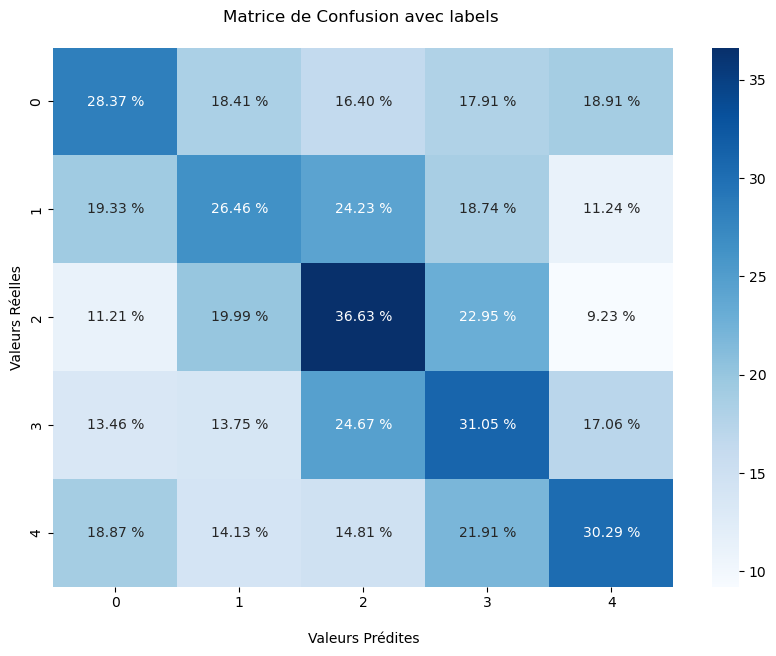

In [37]:
cf_matrix(y_test, pred, pct_row=True)

now there is less of the problem of over-representation of one class
But the prediction are not good, they lean more towards the good class but still way too far from being good. 

## One-Hot Encoding with under-sampled data

We had previously made the decision not to use one-hot encoding, but rather target encoding (also known as mean encoding), because of the size of our dataset. However, if we use the under-sampled data, we could try to use one-hot encoding which should be more precise, and should also not introduce any bias due to the value encoding each move (something that target encoding unfortunalety does). 

In [20]:
moves_df

,game_index,moves,evaluation,fen,zobrist_key,differences,class,target_enc
0,0,e2e4,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...,9384546495678726550,35,2,34.303237
1,0,e7e5,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,595762792459712928,13,2,60.633977
2,0,g1f3,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...,15213300192948443293,63,2,34.887448
3,0,b8c6,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...,8704797333742910878,-64,2,48.062981
4,0,f1b5,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...,5409798013178080797,5,2,42.837878
...,...,...,...,...,...,...,...,...
9023518,118318,a8c8,-6,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP1BP1/1P1BPP1P...,13935396515866781493,-6,2,55.805796
9023519,118318,f3g2,-2,2rq1rk1/pp2bppp/2n1pn2/3p4/8/P1NP2P1/1P1BPPBP/...,18028698229637126573,4,2,-36.787252
9023520,118318,a7a6,12,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,2937820813377462641,14,2,55.584858
9023521,118318,a1c1,25,2rq1rk1/1p2bppp/p1n1pn2/3p4/8/P1NP2P1/1P1BPPBP...,11978245410268853311,13,2,28.956712


In [21]:
print('Original distribution of elements in each class %s' % Counter(moves_df['class']))
rus = RandomUnderSampler()
X_us, y_us = rus.fit_resample(moves_df[['moves', 'zobrist_key']], moves_df['class']) #us stands for under-sampled
print('Resampled distribution of elements in each class %s' % Counter(y_us))

Original distribution of elements in each class Counter({2: 7739068, 1: 691822, 3: 583929, 4: 4727, 0: 3977})
Resampled distribution of elements in each class Counter({0: 3977, 1: 3977, 2: 3977, 3: 3977, 4: 3977})


In [22]:
nb_unique_moves = X_us.moves.nunique()
print(f"There are {nb_unique_moves} unique moves in the under_sampled dataset.")

There are 1738 unique moves in the under_sampled dataset.


##### One-hot encode the moves

In [23]:
onehot_encoding = pd.get_dummies(X_us.moves)

In [24]:
onehot_encoding['zobrist_key'] = X_us.zobrist_key

In [25]:
onehot_encoding

,a1a2,a1a3,a1a4,a1a5,a1a6,a1a7,a1a8,a1b1,a1b2,a1c1,...,h8g7,h8g8,h8h1,h8h2,h8h3,h8h4,h8h5,h8h6,h8h7,zobrist_key
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10853649357106594912
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11133987967973252664
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4632318301205814959
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11553363206125605746
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,16630904955655744247
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19880,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3312530177159218059
19881,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11820963199279613899
19882,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11584058256367518973
19883,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,12403969901301643231


##### Split the set into train/test sets

In [26]:
# we don't stratify this time, unlike we did before, because there is no imbalance in the sets this time
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(onehot_encoding, y_us, test_size=0.20) 

##### Implement Random forests

In [71]:
clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
clf.fit(X_train_us, y_train_us)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [72]:
pred = clf.predict(X_test_us)
accuracy(y_test_us, pred)

Accuracy = 26.65%


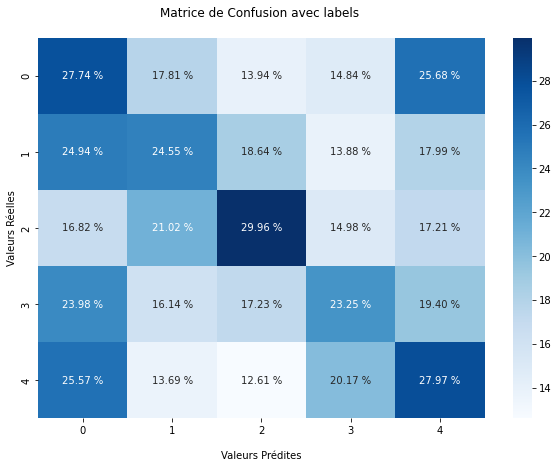

In [73]:
cf_matrix(y_test_us, pred, pct_row=True)

### Try Deep Learning

In [28]:
import tensorflow as tf
from keras.callbacks import EarlyStopping

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #remove warnings caused by tensorflow

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.9.1
Eager mode:  True
GPU is available


In [29]:
y_train_us_dl = tf.keras.utils.to_categorical(y_train_us)
y_test_us_dl = tf.keras.utils.to_categorical(y_test_us)

In [50]:
input_dimension = 32
output_dimension = 64
nb_classes = len(y_train_us_dl[0])

# we use this to randomly initialize the weights in the dense layers, which allows for a faster convergence of the network
kernel_initializing = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=666)

model = tf.keras.Sequential([
    #tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(input_dimension, activation='selu'),
    tf.keras.layers.Reshape((-1, 1)),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(output_dimension, dropout=0.2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(output_dimension, activation='elu'),
    
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(nb_classes, activation='softmax')
])

In [51]:
model.build(X_train_us.shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (15908, 32)               56064     
                                                                 
 reshape_2 (Reshape)         (15908, 32, 1)            0         
                                                                 
 bidirectional_2 (Bidirectio  (15908, 128)             33792     
 nal)                                                            
                                                                 
 batch_normalization_2 (Batc  (15908, 128)             512       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (15908, 64)               8256      
                                                                 
 dropout_2 (Dropout)         (15908, 64)              

In [52]:
model.compile(loss='categorical_crossentropy',
          optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
          metrics=['accuracy'])

In [53]:
es = EarlyStopping(monitor='val_loss', patience=8, verbose=1)

callbacks = [es]

In [54]:
start=time.time()

history = model.fit(X_train_us, y_train_us_dl, batch_size = 64, epochs=10, 
                    validation_data=(X_test_us, y_test_us_dl), 
                    verbose=1, 
                    callbacks=callbacks
                   )

stop=time.time()

Epoch 1/10
249/249 [==============================] - 17s 44ms/step - loss: 1.9252 - accuracy: 0.1993 - val_loss: 1.6133 - val_accuracy: 0.2034
Epoch 2/10
249/249 [==============================] - 10s 39ms/step - loss: 1.8113 - accuracy: 0.1963 - val_loss: 1.6129 - val_accuracy: 0.2034
Epoch 3/10
249/249 [==============================] - 9s 37ms/step - loss: 1.7462 - accuracy: 0.2013 - val_loss: 1.6145 - val_accuracy: 0.2034
Epoch 4/10
249/249 [==============================] - 10s 39ms/step - loss: 1.7295 - accuracy: 0.2033 - val_loss: 1.6121 - val_accuracy: 0.2034
Epoch 5/10
249/249 [==============================] - 11s 42ms/step - loss: 1.7170 - accuracy: 0.2027 - val_loss: 1.6111 - val_accuracy: 0.2034
Epoch 6/10
249/249 [==============================] - 10s 40ms/step - loss: 1.7015 - accuracy: 0.2046 - val_loss: 1.6104 - val_accuracy: 0.2034
Epoch 7/10
249/249 [==============================] - 9s 37ms/step - loss: 1.6902 - accuracy: 0.2044 - val_loss: 1.6097 - val_accuracy: 0

In [55]:
print(f"Took {round(stop-start, 2)}s to run. ")

Took 147.58s to run. 


In [30]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    
def plot_history(history):
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plot_graphs(history, 'accuracy')
    plt.ylim(None, 1)
    plt.subplot(1, 2, 2)
    plot_graphs(history, 'loss')
    plt.ylim(0, None)
    plt.show()

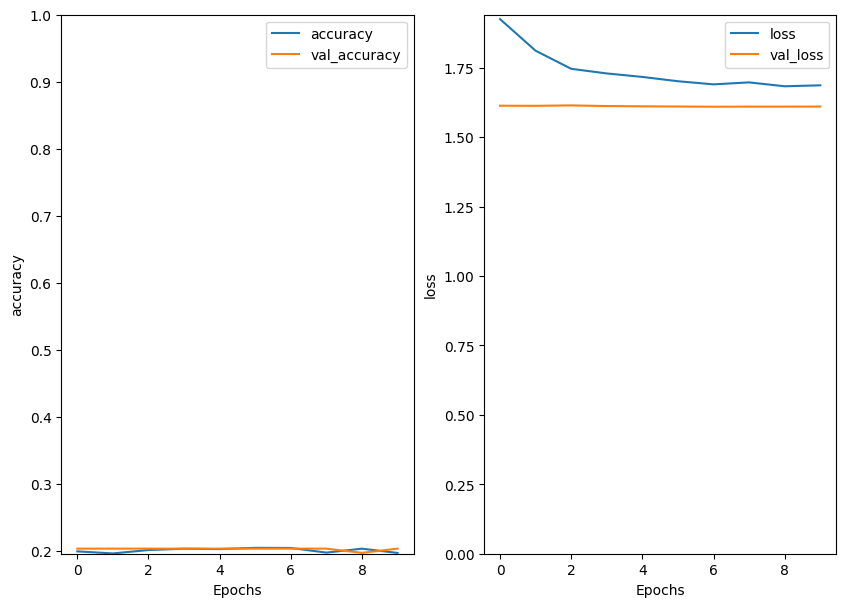

In [57]:
plot_history(history)

### Keras Tuner

In [32]:
import keras_tuner
from tensorflow.keras import layers
from tensorflow import keras

In [33]:
nb_classes = len(y_test_us_dl[0])

In [34]:
def build_model(hp):
    model = keras.Sequential()
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["elu", "selu", "relu"]),
            )
        )
        
    if hp.Boolean("dropout"):
        dropout_rate = hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step = 0.1)
        model.add(layers.Dropout(rate=dropout_rate))
        
    if hp.Boolean("batchNormalization"):
        model.add(layers.BatchNormalization())
        
    if hp.Boolean("LSTM"):
        model.add(layers.Reshape((-1, 1)))
        lstm_dropout = hp.Float("dropout_rate", min_value=0.2, max_value=0.4, step = 0.1)
        model.add(layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=lstm_dropout)))

    for i in range(hp.Int("num_layers", 0, 2)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=32, max_value=512, step=32),
                activation=hp.Choice("activation", ["elu", "selu"]),
            )
        )          
                  
    model.add(layers.Dense(nb_classes, activation="softmax"))


    learning_rate = hp.Float("lr", min_value=1e-5, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

In [44]:
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    #max_trials=5,
    executions_per_trial=3,
    overwrite=True,
    directory="prediction_models",
    project_name="tuner_search_chess",
)

In [45]:
tuner.search_space_summary()

Search space summary
Default search space size: 7
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 3, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
activation (Choice)
{'default': 'elu', 'conditions': [], 'values': ['elu', 'selu', 'relu'], 'ordered': False}
dropout (Boolean)
{'default': False, 'conditions': []}
batchNormalization (Boolean)
{'default': False, 'conditions': []}
LSTM (Boolean)
{'default': False, 'conditions': []}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [46]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)
callbacks = [es]

In [ ]:
tuner.search(X_train_us, y_train_us_dl, epochs=30, validation_data=(X_test_us, y_test_us_dl), callbacks=callbacks)

Trial 7 Complete [00h 02m 49s]
val_accuracy: 0.20367111265659332

Best val_accuracy So Far: 0.2072751671075821
Total elapsed time: 00h 49m 24s

Search: Running Trial #8

Value             |Best Value So Far |Hyperparameter
1                 |1                 |num_layers
480               |96                |units_0
selu              |relu              |activation
True              |True              |dropout
False             |True              |batchNormalization
True              |False             |LSTM
5.3902e-05        |7.56e-05          |lr
0.3               |0.4               |dropout_rate
512               |None              |units_1
384               |None              |units_2

Epoch 1/30
498/498 [==============================] - 196s 384ms/step - loss: 1.6128 - accuracy: 0.1956 - val_loss: 1.6163 - val_accuracy: 0.2037
Epoch 2/30
498/498 [==============================] - 189s 380ms/step - loss: 1.6122 - accuracy: 0.1963 - val_loss: 1.6094 - val_accuracy: 0.2012
Epoch 3/30

We can see that the best accuracy that was found via the keras tuner search was 20%. We have 5 classes, so basically the neural network does not learn any pattern within the data, it just guesses every class for each move, and gets a 1/5 chance everytime to guess the right class. </br>
There is not enough information contained in the zobrist key to represent well enough a chess position for the neural network. From our research, we would need to work with matrices that represent a chess board and its pieces, and use convolutional neural networks to train our AI to understand what a goor or bad move is. 